In [296]:
import anuga
import numpy as np
from hymo import SWMMInpFile
from pyswmm import Simulation, Nodes, Links
import matplotlib.pyplot as plt
import pandas as pd
from pyswmm import SystemStats
import matplotlib
from coupling_functions.coupling import calculate_Q, calculate_Q_v2

do_new_coupling  = False
rain_on_surf     = False
visualise        = True
verbose          = False

time_average = 10 # sec
inlet_width  = 6.0
out_dt       = 2.0 # output step
rf = 20  # refinement factor for domain, if too coarse the inlets will overlap the wall
dt = 0.2     # yield step
ft = 600     # final timestep
cw = 0.6
co = 0.6

if rain_on_surf:
    outname =  'surf_swmm_input_long_culvert_3inlets'
else:
    outname =  'swmm_input_long_culvert_3inlets'

inp_name = outname + '.inp'
inp = SWMMInpFile(inp_name)
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})

baseline_flow  = inp.inflows.Baseline.values[0]
baseline_flow2 = inp.inflows.Baseline.values[1]

domain = anuga.rectangular_cross_domain(3*rf, rf, len1=60, len2=20,verbose = False)

domain.set_minimum_storable_height(0.0001) 
domain.set_name(outname) 

def topography(x,y):
    z = 5*np.ones_like(x)
    channel = np.logical_and(y>5,y<15)
    z = np.where(channel, x/100, z)

    return z

domain.set_quantity('elevation', topography, location='centroids')
domain.set_quantity('friction', 0.035)

Br = anuga.Reflective_boundary(domain)
Bd = anuga.Dirichlet_boundary([-1.0,0,0])

domain.set_boundary({'left': Bd, 'bottom': Bd, 'top': Bd, 'right': Bd})

inlet_polygon = [[50.0, 10-inlet_width/2], [52.0, 10-inlet_width/2], [52.0, 10+inlet_width/2], [50.0, 10+inlet_width/2]]
inlet1_anuga_region = anuga.Region(domain, polygon=inlet_polygon)

inlet2_polygon = [[40.0, 10-inlet_width/2], [42.0, 10-inlet_width/2], [42.0, 10+inlet_width/2], [40.0, 10+inlet_width/2]]
inlet2_anuga_region = anuga.Region(domain, polygon=inlet_polygon)

inlet3_polygon = [[20.0, 10-inlet_width/2], [22.0, 10-inlet_width/2], [22.0, 10+inlet_width/2], [20.0, 10+inlet_width/2]]
inlet3_anuga_region = anuga.Region(domain, polygon=inlet_polygon)

outlet_polygon = [[8.0, 10-inlet_width/2], [10.0, 10-inlet_width/2], [10.0, 10+inlet_width/2], [8.0, 10+inlet_width/2]]
outlet_anuga_region = anuga.Region(domain, polygon=outlet_polygon)

outfall_polygon = [[1.0, 10-inlet_width/2], [2.0, 10-inlet_width/2], [2.0, 10+inlet_width/2], [1.0, 10+inlet_width/2]]
outfall_anuga_region = anuga.Region(domain, polygon=outfall_polygon)

anuga_length_weirs = np.array(4 * [2*inlet_width])
anuga_area_manholes = np.array(4 * [2*inlet_width])

inlet1_anuga_inlet_op = anuga.Inlet_operator(domain, inlet1_anuga_region, Q=0.0, zero_velocity=False)
inlet2_anuga_inlet_op = anuga.Inlet_operator(domain, inlet2_anuga_region, Q=0.0, zero_velocity=False)
inlet3_anuga_inlet_op = anuga.Inlet_operator(domain, inlet3_anuga_region, Q=0.0, zero_velocity=False)
outlet_anuga_inlet_op = anuga.Inlet_operator(domain, outlet_anuga_region, Q=0.0, zero_velocity=False)

inlet1_rain_region = anuga.Region(domain, polygon=inlet_polygon)
if rain_on_surf:
    baseline_flow = 0.5
    rain_anuga_inlet_op   = anuga.Inlet_operator(domain, outlet_anuga_region, Q = baseline_flow, zero_velocity=False)
else:
    rain_anuga_inlet_op   = anuga.Inlet_operator(domain, outlet_anuga_region, Q = 0.0, zero_velocity=False)

anuga_beds = np.array([inlet1_anuga_inlet_op.inlet.get_average_elevation(),
                       inlet2_anuga_inlet_op.inlet.get_average_elevation(),
                       inlet3_anuga_inlet_op.inlet.get_average_elevation(),
                       outlet_anuga_inlet_op.inlet.get_average_elevation()])

sim = Simulation(inp_name)
sim.start()

swmm_inlet1 = Nodes(sim)['Inlet1']
swmm_inlet2 = Nodes(sim)['Inlet2']
swmm_inlet3 = Nodes(sim)['Inlet3']
swmm_outlet = Nodes(sim)['Outlet']
swmm_outfall = Nodes(sim)['Outfall']

swmm_culvert1 = Links(sim)['Conduit1']
swmm_culvert2 = Links(sim)['Conduit2']
swmm_culvert3 = Links(sim)['Conduit3']
swmm_outpipe = Links(sim)['Outpipe']

link_volume_0 = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + swmm_outpipe.volume


 o  Retrieving project data

/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/structures/riverwall.py:124: RuntimeWarning: invalid value encountered in cast
  self.hydraulic_properties_rowIndex=numpy.array([default_int]).astype(int)


In [297]:
system_routing = SystemStats(sim)
inlet_flood_vol = []
inlet_lateral_vol= []
outlet_flood_vol = []
outlet_lateral_vol = []
inlet_flows = []
outlet_flows = []
Q_in_cumu = 0
Q_in_cumus = []
correct_vols = []
real_vols = []
node_head_list = []
conduit_depth_list = []
domain_volumes = []
sewer_volumes = []

inlet1_flood_flows = []
outlet_flood_flows = []

H_js        = []
losses      = []
time_series = []
anuga_ws = []
Q_ins = []
external_flows = []

Q_in_old = np.array([0.0, 0.0, 0.0, 0.0])

cumulative_inlet_flooding  = 0.0
cumulative_outlet_flooding = 0.0
cumulative_inlet_flow      = 0.0
cumulative_outlet_flow     = 0.0

old_outlet_vol = 0.0
old_inlet1_vol = 0.0
old_inlet2_vol = 0.0
old_inlet3_vol = 0.0
old_inlet1_flood   = 0
old_inlet2_flood   = 0
old_inlet3_flood   = 0
old_outlet_flood   = 0

In [298]:
domain.output_frequency = 100
for t in domain.evolve(yieldstep=dt, outputstep=out_dt, finaltime=ft):
    #print('\n')
    print_out = domain.yieldstep_counter%domain.output_frequency == 0
    # print_out = False

    if print_out:
        domain.print_timestepping_statistics()

    anuga_depths = np.array([inlet1_anuga_inlet_op.inlet.get_average_depth(),
                             inlet2_anuga_inlet_op.inlet.get_average_depth(),
                             inlet3_anuga_inlet_op.inlet.get_average_depth(),
                             outlet_anuga_inlet_op.inlet.get_average_depth()])
    
    anuga_stages = np.array([inlet1_anuga_inlet_op.inlet.get_average_stage(),
                             inlet2_anuga_inlet_op.inlet.get_average_stage(),
                             inlet3_anuga_inlet_op.inlet.get_average_stage(),
                             outlet_anuga_inlet_op.inlet.get_average_stage()])

    # Compute the water volumes in the swmm model
    link_volume = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + swmm_outpipe.volume
    node_volume = 0.0
    sewer_volume = link_volume + node_volume

    # Compute anuga water volumes and boundary fluxes
    boundary_flux = domain.get_boundary_flux_integral()
    domain_volume = domain.get_water_volume()

    # Calculate correct and real volumes
    
    # total_volume_correct = baseline_flow * t + 0.5*baseline_flow + boundary_flux  + link_volume_0 - Links(sim)['Outpipe'].flow*dt
    total_volume_correct = (baseline_flow + baseline_flow2) * t + 0.5*(baseline_flow2 + baseline_flow) + boundary_flux  + link_volume_0 - Links(sim)['Outpipe'].flow*dt
    total_volume_real = domain_volume + sewer_volume
    correct_vols.append(total_volume_correct)
    real_vols.append(total_volume_real)

    loss = total_volume_real - total_volume_correct
    external_flows.append(system_routing.routing_stats['external_inflow'])

    # Append data for later plots
    domain_volumes.append(domain_volume)
    sewer_volumes.append(sewer_volume)
    time_series.append(t)
    losses.append(loss)
    conduit_depth_list.append(Links(sim)['Conduit1'].depth)
    conduit_depth_list.append(Links(sim)['Conduit2'].depth)
    conduit_depth_list.append(Links(sim)['Conduit3'].depth)

    anuga_ws.append(anuga_stages.copy())
    H_js.append([node.head for node in Nodes(sim) if node.is_junction()])
    
    # setup some aliases
    inlet1_head  = swmm_inlet1.head
    inlet2_head  = swmm_inlet2.head
    inlet3_head  = swmm_inlet3.head

    outlet_head = swmm_outlet.head
    outfall_head = swmm_outfall.head

    # inlet_invert = swmm_inlet1.invert_elevation
    # outlet_invert = swmm_outlet.invert_elevation
    # outfall_invert = swmm_outfall.invert_elevation
    cumulative_inlet_flooding += swmm_inlet1.flooding*dt 
    cumulative_outlet_flooding += swmm_outlet.flooding*dt

    # Calculate the coupling flux and smooth to response
    node_heads = np.array([inlet1_head, inlet2_head, inlet3_head, outlet_head])

    inlet_volumes = [inlet1_anuga_inlet_op.inlet.get_total_water_volume(),inlet2_anuga_inlet_op.inlet.get_total_water_volume(),inlet3_anuga_inlet_op.inlet.get_total_water_volume(), outlet_anuga_inlet_op.inlet.get_total_water_volume()]
    if do_new_coupling:
        Q_in     = calculate_Q_v2(node_heads, anuga_depths, anuga_beds, anuga_length_weirs, anuga_area_manholes, inlet_volumes = inlet_volumes, dt = dt, cw = cw, co = co)
    else:
        Q_in     = calculate_Q(node_heads, anuga_depths, anuga_beds, anuga_length_weirs, anuga_area_manholes, cw = cw, co = co)

    Q_in     = ((time_average - dt)*Q_in_old + dt*Q_in)/time_average
    Q_in_old = Q_in
    Q_ins.append(Q_in.copy())
    Q_in_cumu += sum(Q_in)
    Q_in_cumus.append(Q_in_cumu)

    # Run SWMM for a time of dt sewer using the calculated coupling fluxes
    swmm_inlet1.generated_inflow(Q_in[0])
    swmm_inlet2.generated_inflow(Q_in[1])
    swmm_inlet3.generated_inflow(Q_in[2])
    swmm_outlet.generated_inflow(Q_in[3])
    sim.step_advance(dt)
    sim.next()

    # Determine how much actually flowed into 1D model
    inlet1_vol = - swmm_inlet1.statistics['lateral_infow_vol'] + swmm_inlet1.statistics['flooding_volume']
    inlet1_flow = (inlet1_vol - old_inlet1_vol)/dt
    old_inlet1_vol = inlet1_vol
    
    inlet2_vol = - swmm_inlet2.statistics['lateral_infow_vol'] + swmm_inlet2.statistics['flooding_volume'] 
    inlet2_flow = (inlet2_vol - old_inlet2_vol)/dt
    old_inlet2_vol = inlet2_vol

    inlet3_vol = - swmm_inlet3.statistics['lateral_infow_vol'] + swmm_inlet3.statistics['flooding_volume'] 
    inlet3_flow = (inlet3_vol - old_inlet3_vol)/dt
    old_inlet3_vol = inlet3_vol

    outlet_vol = - swmm_outlet.statistics['lateral_infow_vol'] + swmm_outlet.statistics['flooding_volume'] 
    outlet_flow = (outlet_vol - old_outlet_vol)/dt
    old_outlet_vol = outlet_vol

    inlet_flows.append(inlet1_flow)
    outlet_flows.append(outlet_flow)

    cumulative_inlet_flow += inlet1_flow*dt
    cumulative_outlet_flow += outlet_flow*dt

    if rain_on_surf:
        inlet1_anuga_inlet_op.set_Q(inlet1_flow)
    else:
        inlet1_anuga_inlet_op.set_Q(inlet1_flow + baseline_flow)

    inlet2_anuga_inlet_op.set_Q(inlet2_flow)
    inlet3_anuga_inlet_op.set_Q(inlet3_flow)
    outlet_anuga_inlet_op.set_Q(outlet_flow + swmm_outfall.total_inflow)

# sim.close()


Time = 0.0000 (sec), steps=0 (0s)
Time = 20.0000 (sec), delta t = 0.26655163 (s), steps=1 (0s)
Time = 40.0000 (sec), delta t in [0.10811772, 0.10881918] (s), steps=2 (0s)
Time = 60.0000 (sec), delta t in [0.10104739, 0.10124321] (s), steps=2 (0s)
Time = 80.0000 (sec), delta t in [0.09246927, 0.09274024] (s), steps=3 (0s)
Time = 100.0000 (sec), delta t in [0.08477109, 0.08501919] (s), steps=3 (0s)
Time = 120.0000 (sec), delta t in [0.09011778, 0.09041825] (s), steps=3 (0s)
Time = 140.0000 (sec), delta t in [0.08870510, 0.09327641] (s), steps=3 (0s)
Time = 160.0000 (sec), delta t in [0.08629546, 0.08768201] (s), steps=3 (0s)
Time = 180.0000 (sec), delta t in [0.08717927, 0.09089902] (s), steps=3 (0s)
Time = 200.0000 (sec), delta t in [0.08809167, 0.08845441] (s), steps=3 (0s)
Time = 220.0000 (sec), delta t in [0.08586287, 0.08634394] (s), steps=3 (0s)
Time = 240.0000 (sec), delta t in [0.08438943, 0.08501953] (s), steps=3 (0s)
Time = 260.0000 (sec), delta t in [0.07980369, 0.08139943] (s

In [299]:
### old loop

# domain.output_frequency = 100
# for t in domain.evolve(yieldstep=dt, outputstep=out_dt, finaltime=ft):
#     #print('\n')
#     print_out = domain.yieldstep_counter%domain.output_frequency == 0
#     # print_out = False

#     if print_out:
#         domain.print_timestepping_statistics()

#     anuga_depths = np.array([inlet1_anuga_inlet_op.inlet.get_average_depth(),
#                              inlet2_anuga_inlet_op.inlet.get_average_depth(),
#                              inlet3_anuga_inlet_op.inlet.get_average_depth(),
#                              outlet_anuga_inlet_op.inlet.get_average_depth()])
    
#     anuga_stages = np.array([inlet1_anuga_inlet_op.inlet.get_average_stage(),
#                              inlet2_anuga_inlet_op.inlet.get_average_stage(),
#                              inlet3_anuga_inlet_op.inlet.get_average_stage(),
#                              outlet_anuga_inlet_op.inlet.get_average_stage()])


#     # Compute the water volumes in the swmm model
#     link_volume = swmm_culvert1.volume + swmm_culvert2.volume +swmm_culvert3.volume + swmm_outpipe.volume
#     node_volume = 0.0
#     sewer_volume = link_volume + node_volume

#     # Compute anuga water volumes and boundary fluxes
#     boundary_flux = domain.get_boundary_flux_integral()
#     domain_volume = domain.get_water_volume()

#     # Calculate correct and real volumes
    
#     # total_volume_correct = baseline_flow * t + 0.5*baseline_flow + boundary_flux  + link_volume_0 - Links(sim)['Outpipe'].flow*dt
#     total_volume_correct = (baseline_flow + baseline_flow2) * t + 0.5*(baseline_flow2 + baseline_flow) + boundary_flux  + link_volume_0 - Links(sim)['Outpipe'].flow*dt
#     total_volume_real = domain_volume + sewer_volume
#     correct_vols.append(total_volume_correct)
#     real_vols.append(total_volume_real)

#     loss = total_volume_real - total_volume_correct
#     external_flows.append(system_routing.routing_stats['external_inflow'])

    

#     # Append data for later plots
#     domain_volumes.append(domain_volume)
#     sewer_volumes.append(sewer_volume)
#     time_series.append(t)
#     losses.append(loss)
#     conduit_depth_list.append(Links(sim)['Conduit1'].depth)
#     conduit_depth_list.append(Links(sim)['Conduit2'].depth)
#     conduit_depth_list.append(Links(sim)['Conduit3'].depth)

#     anuga_ws.append(anuga_stages.copy())
#     H_js.append([node.head for node in Nodes(sim) if node.is_junction()])
    

#     # setup some aliases
#     inlet1_head  = swmm_inlet1.head
#     inlet2_head  = swmm_inlet2.head
#     inlet3_head  = swmm_inlet3.head

#     outlet_head = swmm_outlet.head
#     outfall_head = swmm_outfall.head

#     cumulative_inlet_flooding += swmm_inlet1.flooding*dt 
#     cumulative_outlet_flooding += swmm_outlet.flooding*dt

#     # Calculate the coupling flux and smooth to response
#     node_heads = np.array([inlet1_head, inlet2_head, inlet3_head, outlet_head])

#     if do_new_coupling:    
#         inlet_volumes = [inlet1_anuga_inlet_op.inlet.get_total_water_volume(),inlet2_anuga_inlet_op.inlet.get_total_water_volume(),inlet3_anuga_inlet_op.inlet.get_total_water_volume(), outlet_anuga_inlet_op.inlet.get_total_water_volume()]
#         Q_in     = calculate_Q_v2(node_heads, anuga_depths, anuga_beds, anuga_length_weirs, anuga_area_manholes, inlet_volumes = inlet_volumes, dt = dt, cw = cw, co = co)
#     else:
#         Q_in     = calculate_Q(node_heads, anuga_depths, anuga_beds, anuga_length_weirs, anuga_area_manholes, cw = cw, co = co)


#     Q_in     = 1.0*((time_average - dt)*Q_in_old + dt*Q_in)/time_average
#     Q_in_old = Q_in
#     Q_ins.append(Q_in.copy())
#     Q_in_cumu += sum(Q_in)
#     Q_in_cumus.append(Q_in_cumu)

#     if print_out:
#         print('    Calculated Q     ', Q_in[0], Q_in[1]) 

#     # Run SWMM for a time of dt sewer using the calculated coupling fluxes
#     swmm_inlet1.generated_inflow(Q_in[0])
#     swmm_inlet2.generated_inflow(Q_in[1])
#     swmm_inlet3.generated_inflow(Q_in[2])
#     swmm_outlet.generated_inflow(Q_in[3])
#     sim.step_advance(dt)
#     sim.next()

#     # Determine how much actually flowed into 1D model
#     inlet1_vol = - swmm_inlet1.statistics['lateral_infow_vol'] + swmm_inlet1.statistics['flooding_volume']
#     inlet1_flow = (inlet1_vol - old_inlet1_vol)/dt
#     old_inlet1_vol = inlet1_vol
    
#     inlet2_vol = - swmm_inlet2.statistics['lateral_infow_vol'] + swmm_inlet2.statistics['flooding_volume'] 
#     inlet2_flow = (inlet2_vol - old_inlet2_vol)/dt
#     old_inlet2_vol = inlet2_vol

#     inlet3_vol = - swmm_inlet3.statistics['lateral_infow_vol'] + swmm_inlet3.statistics['flooding_volume'] 
#     inlet3_flow = (inlet3_vol - old_inlet3_vol)/dt
#     old_inlet3_vol = inlet3_vol

#     outlet_vol = - swmm_outlet.statistics['lateral_infow_vol'] + swmm_outlet.statistics['flooding_volume'] 
#     outlet_flow = (outlet_vol - old_outlet_vol)/dt
#     old_outlet_vol = outlet_vol

#     inlet_flows.append(inlet1_flow)
#     outlet_flows.append(outlet_flow)

#     if rain_on_surf:
#         inlet1_anuga_inlet_op.set_Q(inlet1_flow)
#     else:
#         inlet1_anuga_inlet_op.set_Q(inlet1_flow + baseline_flow)

#     inlet2_anuga_inlet_op.set_Q(inlet2_flow)
#     inlet3_anuga_inlet_op.set_Q(inlet3_flow)
#     outlet_anuga_inlet_op.set_Q(outlet_flow + swmm_outfall.total_inflow)


# # sim.close()


In [300]:
print(f'Rain on surface: {rain_on_surf}')
print(f'Do new coupling: {do_new_coupling}')
print(f'Inlet width: {inlet_width}')
print(f'cw,co = {cw}, {co}')

print(f'rain_anuga_inlet_op.get_applied_Q() = {rain_anuga_inlet_op.get_applied_Q()}')

Rain on surface: False
Do new coupling: False
Inlet width: 6.0
cw,co = 0.6, 0.6
rain_anuga_inlet_op.get_applied_Q() = 0.0


In [301]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 07/03/2023 14:44:56


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


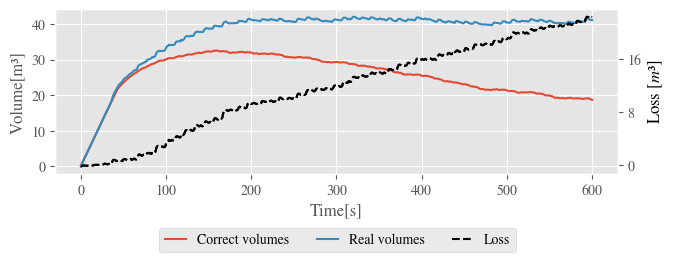

In [302]:
inch = 2.54
fig_size = 17

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(time_series,correct_vols,label = 'Correct volumes')
ax.plot(time_series,real_vols, label = 'Real volumes')
ax.set_xlabel('Time[s]')
ax.set_ylabel('Volume[m³]')

diff_ax = ax.twinx()
diff_ax.plot(time_series,losses,label = 'Loss',color = 'k',linestyle = '--')
diff_ax.plot(time_series,np.array(real_vols)- np.array(correct_vols),label = 'Loss',color = 'k',linestyle = '--')

diff_ax.grid(False)
diff_ax.set_ylabel('Loss [$m³$]')
diff_ax.yaxis.set_major_locator(plt.MaxNLocator(4))

diff_ax.yaxis.label.set_color(diff_ax.get_lines()[0].get_color())
ax.plot([],[],color = 'k',linestyle = '--',label = 'Loss')


fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)
if True:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    if do_new_coupling:
        plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
        plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_new_coupling' + '_swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')

    else: 
        plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_old_coupling' + 'swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.eps', bbox_inches='tight')
        plt.savefig('plots/mass_convservatio_3inlet_width' + str(inlet_width) + '_old_coupling' + 'swmm_correction' + '_tavg_' + str(time_average) + '_cms_in_' + str(baseline_flow)  + '.png', bbox_inches='tight')


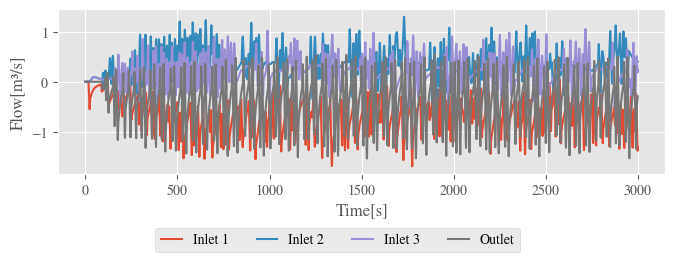

In [303]:

inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

ax.plot(Q_ins,label = ['Inlet 1' , 'Inlet 2', 'Inlet 3', 'Outlet'])
ax.set_xlabel('Time[s]')
ax.set_ylabel('Flow[m³/s]')
fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)

When pipe is filled it starts to flood

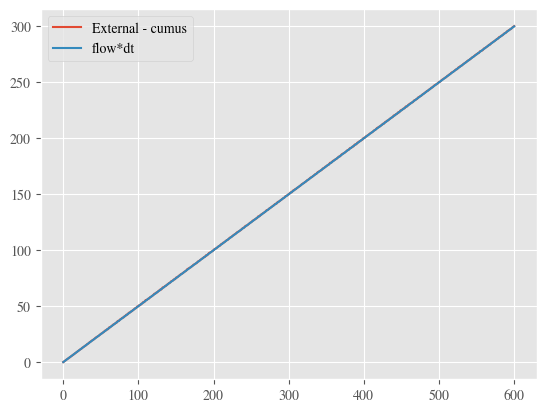

In [304]:
plt.plot(time_series, external_flows-np.array(Q_in_cumus)*dt,label = 'External - cumus')
plt.plot(time_series, baseline_flow*np.array(time_series),label = 'flow*dt')

plt.legend()

In [305]:
# inch = 2.54
# fig_size = 17
# # fig_size = 34

# fig_size = fig_size/inch
# fig_aspect = 3
# fig, ax = plt.subplots(1,1)
# fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)

# # ax.axvline(65,color = 'k',linestyle = '--')
# ax.plot(time_series,conduit_depth_list)
# ax.set_ylabel('Conduit depth[m]')
# ax.axvline(55, color = 'k' , linestyle = '--')

# ax.set_xlabel('Time[s]')


# fig.tight_layout(pad = .5)
# # handles, labels = ax.get_legend_handles_labels()
# lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)

In [306]:
inlet_lateral_vol_array = np.array(inlet_lateral_vol)
inlet_lateral_vol_array = np.insert(inlet_lateral_vol_array,0,np.array([0,0,0,0]),axis = 0)
lateral_inflows = (inlet_lateral_vol_array[1:]-inlet_lateral_vol_array[0:-1])/dt

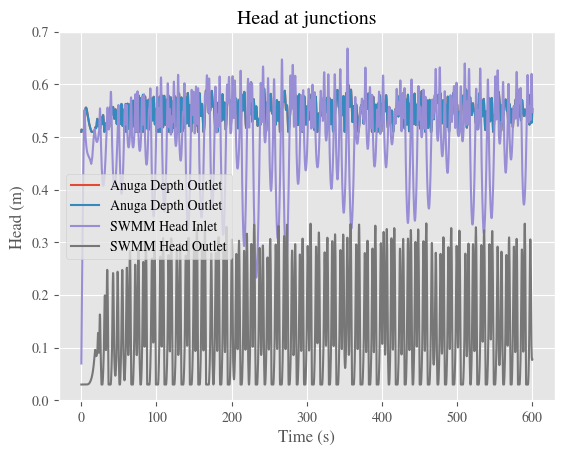

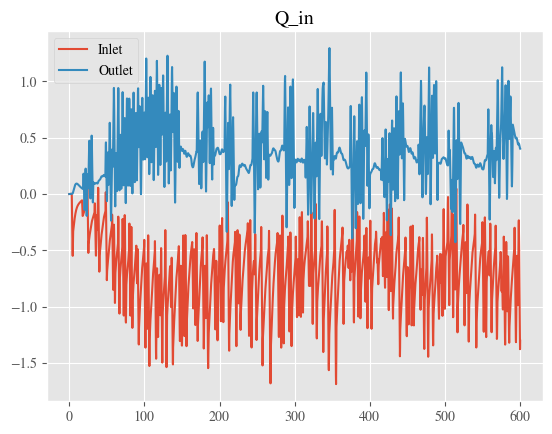

In [307]:
if visualise:
    H_j = np.vstack(H_js)
    anuga_j = np.vstack(anuga_ws)
    Q_ins = np.vstack(Q_ins)

    plt.ion()

    plt.figure(1)
    # plt.plot(time_series, anuga_j[:,0], linestyle = '-',label='Anuga Inlet 0')
    # plt.plot(time_series, anuga_j[:,1], linestyle = '-', label='Anuga Inlet 1')
    # plt.plot(time_series, H_j[:,0], label='Pipe Inlet 0')
    # plt.plot(time_series, H_j[:,1], label='Pipe Inlet 1')
    plt.plot(time_series, anuga_j[:,0], linestyle = '-',label='Anuga Depth Outlet')
    plt.plot(time_series, anuga_j[:,1], linestyle = '-', label='Anuga Depth Outlet')
    plt.plot(time_series, H_j[:,0], label='SWMM Head Inlet')
    plt.plot(time_series, H_j[:,1], label='SWMM Head Outlet')

    # plt.plot([time_series[0], time_series[-1]],2*[inp.junctions.Max_Depth.values[0] + inp.junctions.Surcharge_Depth.values[0]])

    plt.legend()
    plt.title('Head at junctions')
    plt.xlabel('Time (s)')
    plt.ylabel('Head (m)')
    # plt.savefig('Figure1.png')
    plt.show()

    plt.figure(4)
    plt.clf()
    plt.plot(time_series, Q_ins[:,0], label='Inlet')
    plt.plot(time_series, Q_ins[:,1], label='Outlet')
    plt.legend()
    plt.title('Q_in')
    # plt.savefig('Figure4.png')
    plt.show()

In [308]:
np.cumsum(Q_ins,axis = 0)[-1,:]

array([-2071.48969326,  1094.41105385,   653.04569675, -1203.26763904])

In [309]:
np.sum(np.cumsum(Q_ins,axis = 0),axis = 1)

array([ 0.00000000e+00,  5.14392846e-04,  1.49080746e-03, ...,
       -1.52522602e+03, -1.52633894e+03, -1.52730058e+03])

In [310]:
np.cumsum(Q_ins)

array([    0.        ,     0.        ,     0.        , ...,
       -1527.23909894, -1527.01032797, -1527.30058171])

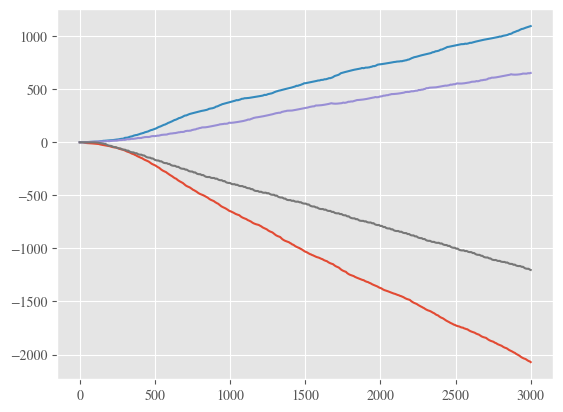

In [311]:
# plt.plot(Q_ins)
plt.plot(np.cumsum(Q_ins,axis = 0))

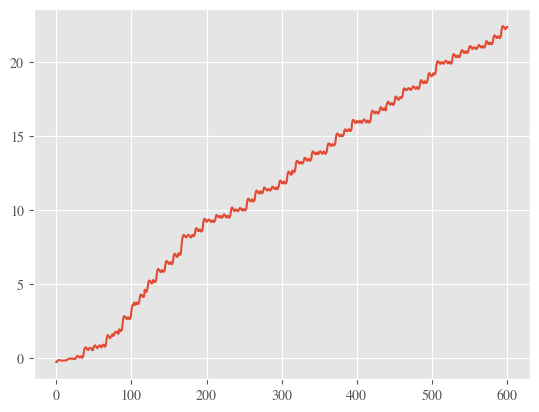

In [312]:
plt.plot(time_series,losses)

In [313]:
(losses[-1]-losses[100])/(time_series[-1]-time_series[100])

0.03861164345016764

In [314]:
loss

22.374358585011592

In [315]:
sum(Q_ins)

array([-2071.48969326,  1094.41105385,   653.04569675, -1203.26763904])